# Stanford cars try with PyTorch FastAi

In [50]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import scipy.io as sio

In [51]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
bs=16

## Prepare data

In [7]:
path='C:/Users/Aleksandra/PythonProjects/StanfordCars'

In [8]:
car_annos = sio.loadmat(path + '/cars_annos.mat')

In [9]:
car_meta = sio.loadmat(path + '/car_devkit/devkit/cars_meta.mat')

In [10]:
train_path=path+'/anno_train.csv'

In [11]:
test_path=path+'/anno_test.csv'

In [12]:
names_path=path+'/names.csv'

In [13]:
train_df=pd.read_csv(train_path)

In [14]:
train_df.columns = ['file_name','bbox_x1','bbox_y1','bbox_x2','bbox_y2','ClassID']

In [15]:
test_df=pd.read_csv(test_path)
test_df.columns = ['file_name','bbox_x1','bbox_y1','bbox_x2','bbox_y2','ClassID']

In [16]:
names_df=pd.read_csv(names_path)

In [17]:
train_df.sample()

,file_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,ClassID
2821,02823.jpg,90,18,480,316,40


In [18]:
names_df.sample()

,AM General Hummer SUV 2000
20,Audi S5 Coupe 2012


In [18]:
class_names = []

with open(path + '/names.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter=';')
    for row in csvReader:
        class_names.append(row[0])

print(class_names)

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012

In [19]:
nclasses = len(class_names)

In [20]:
nclasses

196

In [21]:
class_names = dict(zip(range(1,nclasses),[c[0] for c in car_meta["class_names"][0]]))

In [31]:
class_names

{1: 'AM General Hummer SUV 2000',
 2: 'Acura RL Sedan 2012',
 3: 'Acura TL Sedan 2012',
 4: 'Acura TL Type-S 2008',
 5: 'Acura TSX Sedan 2012',
 6: 'Acura Integra Type R 2001',
 7: 'Acura ZDX Hatchback 2012',
 8: 'Aston Martin V8 Vantage Convertible 2012',
 9: 'Aston Martin V8 Vantage Coupe 2012',
 10: 'Aston Martin Virage Convertible 2012',
 11: 'Aston Martin Virage Coupe 2012',
 12: 'Audi RS 4 Convertible 2008',
 13: 'Audi A5 Coupe 2012',
 14: 'Audi TTS Coupe 2012',
 15: 'Audi R8 Coupe 2012',
 16: 'Audi V8 Sedan 1994',
 17: 'Audi 100 Sedan 1994',
 18: 'Audi 100 Wagon 1994',
 19: 'Audi TT Hatchback 2011',
 20: 'Audi S6 Sedan 2011',
 21: 'Audi S5 Convertible 2012',
 22: 'Audi S5 Coupe 2012',
 23: 'Audi S4 Sedan 2012',
 24: 'Audi S4 Sedan 2007',
 25: 'Audi TT RS Coupe 2012',
 26: 'BMW ActiveHybrid 5 Sedan 2012',
 27: 'BMW 1 Series Convertible 2012',
 28: 'BMW 1 Series Coupe 2012',
 29: 'BMW 3 Series Sedan 2012',
 30: 'BMW 3 Series Wagon 2012',
 31: 'BMW 6 Series Convertible 2007',
 32: 

In [32]:
train_df = train_df.assign(ClassName=train_df.ClassID.map(dict(class_names)))

In [33]:
train_df['is_test'] = 0

In [34]:
train_df.sample()

,file_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,ClassID,ClassName,is_test
6696,06698.jpg,33,57,255,162,165,Mercedes-Benz S-Class Sedan 2012,0


In [35]:
test_df['is_test'] = 1

In [36]:
train_df['ClassName'].nunique(), train_df['ClassID'].nunique()

(195, 196)

In [37]:
#bb_fastai is of the format hw_bb

In [38]:
train_df['bbox_h'] = (train_df['bbox_y2'] - train_df['bbox_y1']) + 1
train_df['bbox_w'] = (train_df['bbox_x2'] - train_df['bbox_x1']) + 1
train_df.head()

,file_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,ClassID,ClassName,is_test,bbox_h,bbox_w
0,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0,472,833
1,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0,273,517
2,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,0,704,864
3,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,0,64,120
4,00006.jpg,259,289,515,416,123,Geo Metro Convertible 1993,0,128,257


In [39]:
#list for bounding boxes

In [40]:
bb_hw = train_df[['bbox_x1', 'bbox_y1','bbox_h', 'bbox_w']].values
hw_bb = train_df[['bbox_h', 'bbox_w', 'bbox_x1', 'bbox_y1']].values
bb_hw

array([[  36,  116,  472,  833],
       [  85,  109,  273,  517],
       [ 621,  393,  704,  864],
       [  14,   36,   64,  120],
       ...,
       [ 138,  150,  374,  569],
       [  26,  246,  204,  635],
       [  78,  526,  383, 1412],
       [  20,  240,  438,  843]], dtype=int64)

In [41]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

# White text on black outline
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
#     patch = ax.add_patch(patches.Rectangle(xy, w,h, fill=False, edgecolor='white', lw=2))
    patch = ax.add_patch(patches.Rectangle(b[:2], b[3], b[2], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [42]:

def compare_top_losses(k, interp, labels_df, num_imgs):
    tl_val,tl_idx = interp.top_losses(k)
    classes = interp.data.classes
    probs = interp.probs
    columns = 2
    rows = 2
    
    topl_idx = 0   
    for i,idx in enumerate(tl_idx):
        fig=plt.figure(figsize=(10, 8))
        columns = 2
        rows = 1
        
        # Actual Image
        act_im, cl = interp.data.valid_ds[idx]
        cl = int(cl)        
        act_cl = classes[cl]
        act_fn = train_df.loc[train_df['class_name'] == act_cl]['filename'].values[0]
        
        # Predicted Image
        pred_cl = interp.pred_class[idx]
        pred_cl = classes[pred_cl]
        pred_fn = train_df.loc[train_df['class_name'] == pred_cl]['filename'].values[0]
        
        print(f'PREDICTION:{pred_cl}, ACTUAL:{act_cl}')
        print(f'Loss: {tl_val[i]:.2f}, Probability: {probs[i][cl]:.4f}')
              
        # Add image to the left column
        img_path = 'train/' + pred_fn
        im = plt.imread(path+img_path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(im)
        
        # Add image to the right column, need to change the tensor shape (permute) for matplotlib
        perm = act_im.data.permute(1,2,0)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(perm)

        plt.show()

In [43]:
def compare_most_confused(most_confused, train_df, num_imgs, rank):
    c1 = most_confused[:][rank][0]
    c2 = most_confused[:][rank][1]
    n_confused = most_confused[:3][0][1]
    print(most_confused[:][rank])
      
    # set the list of 
    f_1 = train_df.loc[train_df['class_name'] == c1]['filename'].values
    f_2 = train_df.loc[train_df['class_name'] == c2]['filename'].values

    fig=plt.figure(figsize=(10, 8))
    columns = 2
    rows = num_imgs
    for i in range(1, columns*rows +1, 2):
        # Add image to the left column
        img_path = 'train/' + f_1[i]
        im = plt.imread(path+img_path)
        fig.add_subplot(rows, columns, i)
        plt.imshow(im)
        
        # Add image to the right column
        img_path = 'train/' + f_2[i]
        im = plt.imread(path+img_path)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(im)

    plt.show()

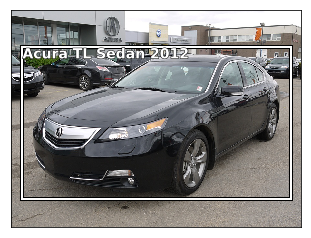

In [44]:
img_path = '/cars_train/cars_train/' + train_df['file_name'][0]

im = plt.imread(path+img_path)
idx = 0
b = bb_hw[idx]

c = train_df['ClassName'].values[idx]

ax = show_img(im)
draw_rect(ax, b)
draw_text(ax, b[:2], c, sz=14)

In [45]:
def crop(df, path, i):
    image = plt.imread(path + df['file_name'][i])
    x1 = df['bbox_x1'][i]
    y1 = df['bbox_y1'][i]
    h = df['bbox_h'][i]
    w = df['bbox_w'][i]
    
    if len(image.shape) == 3:
        return image[y1:y1+h , x1:x1+w, :]
    else:
        # If there are only 2 channels for the image
        return image[y1:y1+h , x1:x1+w]

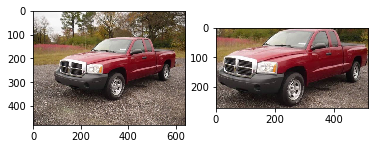

In [46]:
fig = plt.figure()
ax = fig.add_subplot(121)
p = path + '/cars_train/cars_train/'

ax.imshow(plt.imread(p + train_df['file_name'][1]))

ax1 = fig.add_subplot(122)
ax1.imshow(crop(train_df,p, 1))

plt.show()

In [47]:
# Add missing class name! - 'smart fortwo Convertible 2012'
train_df.loc[train_df['ClassName'].isnull(), 'ClassName'] = 'smart fortwo Convertible 2012'

In [52]:
path2=path+'/cars_train/'

## Load data to databunch object 

In [53]:

SZ = 224
SEED = 42
LABEL = 'ClassName'

car_tfms = get_transforms()

trn_labels_df = train_df.loc[train_df['is_test']==0, ['file_name', 'ClassName', 'ClassId']].copy()

src = (ImageItemList.from_df(trn_labels_df, path2, folder='cars_train', cols='file_name')
                    .random_split_by_pct(valid_pct=0.2, seed=SEED)
                    .label_from_df(cols=LABEL))

data = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

D:\Anaconda3\Lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


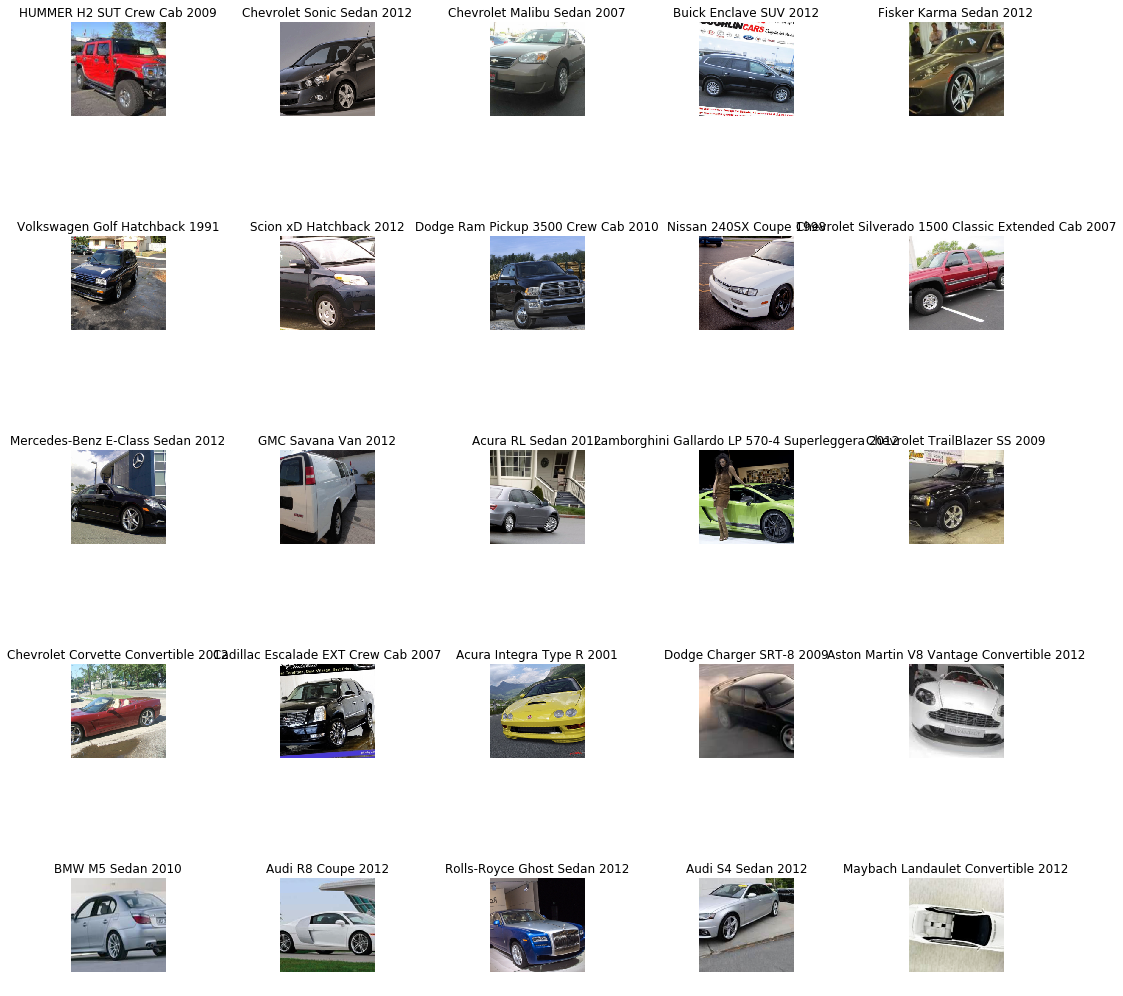

In [54]:

data.show_batch(rows=5, figsize=(15,15))

Acura TL Sedan 2012


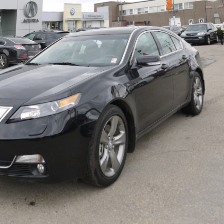

In [55]:
ds = data.train_ds

img,label = ds[0]
print(label)
img

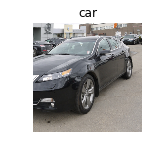

In [56]:
img.show(figsize=(2,2), title='car')

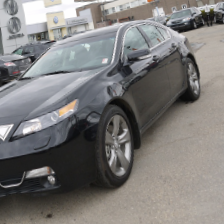

In [57]:
img.rotate(10)

## Training with Resnet152

In [58]:
arch = models.resnet152

In [59]:
data.batch_size = 32
data.batch_size

32

In [60]:
#create convolution NN learner
learn = create_cnn(data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\Aleksandra/.torch\models\resnet152-b121ed2d.pth
100%|███████████████████████| 241530880/241530880 [00:38<00:00, 6336414.22it/s]


In [61]:
#starting point for the learning rate 
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 594.13 MiB (GPU 0; 2.00 GiB total capacity; 717.37 MiB already allocated; 673.89 MiB free; 3.75 MiB cached)

In [ ]:
lr = 1e-2

In [47]:
#14 epochs training
learn.fit_one_cycle(14, max_lr = lr)

NameError: name 'learn' is not defined

In [ ]:

learn.save('stage-1-rn152-bench')

In [ ]:
#Unfreezing all layers of the model allows fine tuning of the earlier layers
learn.unfreeze()

In [ ]:
data.batch_size = 16
data.batch_size

In [ ]:
learn.lr_find(start_lr=1e-8, end_lr=9e-1, num_it=200)
learn.recorder.plot()

In [ ]:
lr = 1e-7
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
learn.fit_one_cycle(5, lrs)

In [ ]:
learn.save('stage-2-rn152-bench')

In [ ]:

# Testing with higher LR and unfrozen layers
learn.load('stage-1-rn152-bench')
learn.unfreeze()
data.batch_size = 16

lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])

learn.fit_one_cycle(6, lrs)

In [ ]:
#find new lr
learn.lr_find()
learn.recorder.plot()

In [ ]:
#try with much smaller lr
lr = 5e-5
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
#some more epochs
learn.fit_one_cycle(3, lrs)

In [ ]:
#Resize the dataset, freeze the earlier layers again and continue learning.
SZ = 299
SEED = 42
LABEL = 'class_name'

car_tfms = get_transforms()

data = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

data.batch_size = 16

print(data.batch_size)
data.train_ds[0][0].shape

In [ ]:
learn.data = data

In [ ]:
learn.freeze()

In [ ]:
#find new lr
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=3e-6

In [ ]:
learn.fit_one_cycle(5, max_lr = slice(lr))

In [ ]:
learn.save('stage-3-rn152-bench')

In [ ]:

learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [ ]:
#find new lr
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 5e-5
lrs = np.array([lr/9,lr/3,lr])

In [ ]:

learn.fit_one_cycle(3, lrs)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.freeze()

In [ ]:
learn.save('stage-4-rn152-bench')

## Results

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(9,9))

NameError: name 'learn' is not defined

In [49]:
#Get most confused models
most_confused = interp.most_confused()

NameError: name 'interp' is not defined

In [ ]:

for i in range(0,8):
    compare_most_confused(most_confused=most_confused, labels_df=labels_df, 
                          num_imgs=3, rank=i)

In [ ]:
compare_top_losses(10, interp, labels_df, 1)

## Test set performance

In [ ]:

SZ = 299
SEED = 42
LABEL = 'class_name'

car_tfms = get_transforms()

src = (ImageItemList.from_df(labels_df, path, folder='merged', cols='filename')
       # the 'is_test' column has values of 1 for the test set
       .split_from_df(col='is_test')
       .label_from_df(cols=LABEL))

data_test = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

In [ ]:
learn.data = data_test

In [52]:
#Use Test Time Augmentation (TTA) 
test_preds, test_ys = learn.TTA()

NameError: name 'learn' is not defined

In [ ]:
#Check Top Accuracy

In [ ]:
accuracy(test_preds, test_ys)

In [ ]:
def accuracy_topk(output, target, topk=(3,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
accuracy_topk(test_preds, test_ys, topk=(5,))

# New heading